In [2]:
def find_degree(node, graph):
  degree = 0
  for edge in graph:
    if edge[0] == node:
      degree += 1
  return degree

def make_deg_dict(graph, curr_nodes):
  degDict = {}
  for i in curr_nodes:
    degDict[i] = find_degree(i, graph)
  return degDict

def sum_degs(graph, curr_nodes):
  sum = 0
  for node in curr_nodes:
    deg = find_degree(node, graph)
    sum += deg
  return sum

def pref_attachment(graph, curr_nodes,n, N):
  degDict = make_deg_dict(graph, curr_nodes)
  for i in range(N):
    new_node = n + i
    degDict[new_node] = 0
    for node in curr_nodes:
      deg = degDict[node]
      sum = sum_degs(graph, curr_nodes)
      p_node = deg/sum
      if np.random.rand() < p_node:
        graph.append([node, new_node])
        degDict[node] += 1
        graph.append([new_node, node])
        degDict[new_node] += 1
    curr_nodes.append(new_node)
  return graph

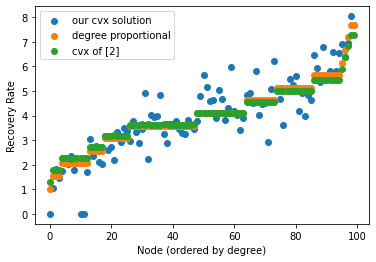

In [1]:
import cvxpy as cp
import numpy as np
import matplotlib.pyplot as plt
import random
import math
def erdos_renyi_graph(N, M):
  graph = []
  node_list = [i for i in range(N)]
  numEdges = 0
  while numEdges < M:
    edge = random.sample(node_list, 2)
    if edge not in graph:
      numEdges += 1
      graph.append(edge)
  return graph

def regular_lattice(N):
  size = int(math.sqrt(N))
  if (size**2 != N):
    size = size
  lattice = []
  i = 0
  while (i < N):
    row = []
    for _ in range(size):
      if (i > N):
        row.append(0)
      else:
        row.append(i)
        i += 1
    lattice.append(row)
  print(lattice)
  graph = []
  for i in range(size):
    for j in range(size):
      graph.append([lattice[i][j], lattice[i][(j+1)% size]])
      graph.append([lattice[i][(j+1)% size], lattice[i][j]])
      
  for i in range(size):
    for j in range(size):
      graph.append([lattice[i][j], lattice[(i+1)%size][j]])
      graph.append([lattice[(i+1)%size][j], lattice[i][j]])
  return graph

def stochastic_block(n, r, P):
  graph = []
  node_list = np.arange(n)
  communities = np.array_split(node_list, r)
  for i in range(r):
    for j in range(r):
      C_i = communities[i]
      C_j = communities[j]
      p_ij = P[i][j]
      for node1 in C_i:
        for node2 in C_j:
          if node1 != node2:
            if np.random.rand() < p_ij:
                graph.append([node1, node2])
  return graph

def barbell(n1, n2):
  graph = []
  for node in range(0, n1):
    for neighbor in range(0, n1):
      if (node != neighbor):
        graph.append([node, neighbor])
  for node in range(n1, n1+n2):
    for neighbor in range(n1, n1+n2):
      if (node != neighbor):
        graph.append([node, neighbor])
  node1 = np.random.randint(0, n1)
  node2 = np.random.randint(n1, n1+n2)
  graph.append([node1, node2])
  graph.append([node2, node1])
  return graph
def tuples_to_adj(graph, N):
    #print (N)
    adj_matrix = np.zeros((N, N))
    for edge in graph:
        adj_matrix[edge[0]][edge[1]] = 1
        adj_matrix[edge[1]][edge[0]] = 1
    #print (adj_matrix)
    return adj_matrix

def cvx_find_rho(A, beta, budget, N, eps=0):
    w = cp.Variable(N)
    z = cp.Variable(N)
    log_of_budget = np.log(1/budget)
    y = np.log(beta*np.ones(N))
    objective = cp.Minimize(cp.atoms.log_sum_exp(w)) #cp.log(1 + cp.sum(cp.exp(w))) ~ sum(v)
    constraints = [cp.atoms.log_sum_exp(z + np.ones(N)*log_of_budget) <= 0]
    for i in range(N):
      inds = []
      for j in range(N):
        if (A[i][j] == 1):
          inds.append(j)
      new_vec = (w + y)[inds]
      new_vec_y = y[inds]
      if len(inds) > 0:
        constraints.append(cp.atoms.log_sum_exp(cp.hstack([new_vec, new_vec_y]))- (w[i] + z[i]) + eps <= 0)
    prob = cp.Problem(objective, constraints)
    # try:
    prob.solve()
    # except:
    #   return []
    try:
      return np.exp(z.value) # A numpy ndarray.
    except:
      return []

def cvx_halfEdge(graph, beta, budget, N, M, x, j, init_inf_edges, eps=0):
  w = cp.Variable(M)   # arbitrary vector, log(v - x)
  y = np.ones(M)*beta  # trasmission rate (constant)
  z = cp.Variable(N)   # optimal recovery rates of each node
  log_of_budget = np.log(1/budget)  # budget
  X = np.diag(x)    # inverse of edge degrees
  # init inf edges = I(0)
  # j is a vector where j(k, l) is 1 when the edge (k, l) is susceptible at time 0
  log_x = np.log(x)
  objective = cp.Minimize(cp.atoms.log_sum_exp(cp.hstack([w, log_x])))
  constraints = []
  for index in range(M):
    edge = graph[index] #(i, j)
    nbr_inds = []
    # Choosing the indices such that the edge ends at node 0 but is not back-tracking
    for i in range(M): #not (j, i) but an edge of the form (u, i)
      if graph[i][1] == edge[0] and graph[i][0] != edge[1]:
        nbr_inds.append(i)
    new_w = w[nbr_inds]
    log_new_x = np.log(x[nbr_inds])
    # print (log_new_x)
    new_j = np.log(j[nbr_inds])
    new_y = np.log(y[nbr_inds])
    # print (graph[index][0])
    if len(nbr_inds) > 0:
      constraints.append(cp.atoms.log_sum_exp(cp.hstack([new_w + new_j + new_y, log_new_x + new_j + new_y])) - (w[index] + z[graph[index][0]]) + eps <=0)
  constraints.append(cp.atoms.log_sum_exp(z + np.ones(N)*log_of_budget) <= 0) #log_of_budget = log(1/budget)
  prob = cp.Problem(objective, constraints)
  try: 
    prob.solve()
  except:
    return []
  try:
    return np.exp(z.value)
  except:
    return []

def cvx_halfedge2(A, graph, beta, budget, N, M, x, eps=0):
  w = cp.Variable(M)   # arbitrary vector, log(v - x)
  y = np.ones(M)*beta  # trasmission rate (constant)
  z = cp.Variable(N)   # optimal recovery rates of each node
  log_of_budget = np.log(1/budget)  # budget
  X = np.diag(x)    # inverse of edge degrees
  log_x = np.log(x)

  objective = cp.Minimize(cp.atoms.log_sum_exp(cp.hstack([w, log_x])))
  constraints = []
  for i in range(M):
    nbr_inds = []
    for j in range(M):
      if A[i][j] == 1:
        nbr_inds.append(j)
    new_w = w[nbr_inds]
    log_new_x = np.log(x[nbr_inds])
    new_y = np.log(y[nbr_inds])
    if len(nbr_inds) > 0:
      constraints.append(cp.atoms.log_sum_exp(cp.hstack([new_w + + new_y, log_new_x + new_y])) - (w[i] + z[graph[i][0]]) + eps <=0)
  constraints.append(cp.atoms.log_sum_exp(z + np.ones(N)*log_of_budget) <= 0) #log_of_budget = log(1/budget)
  rob = cp.Problem(objective, constraints)
  prob.solve()
  return np.exp(z.value)


def generate_nonbacktracking(graph):
  M = len(graph)
  A = np.zeros((M, M))
  for i in range(M):
    for j in range(M):
      edge1 = graph[i]
      edge2 = graph[j]
      if edge2[0] == edge1[1] and edge2[1] != edge1[0]:
        A[i][j] = 1
  return A

  

def find_x(graph):
  x = []
  degDict = {}
  for edge in graph:
    if edge[0] not in degDict:
        degDict[edge[0]] = 0
    degDict[edge[0]] += 1
  for edge in graph:
    x.append(1/degDict[edge[0]])
  return np.array(x)

def tuples_to_dict(graph, N):
  graph_dict = {}
  for i in range(N):
    graph_dict[i] = []
  for edge in graph:
    graph_dict[edge[0]].append(edge[1])
  return graph_dict
N = 100
M = 400
beta = 0.4
r = 2
P = np.zeros((r,r))
P[0][0] = 0.4
P[1][1] = 0.4
P[0][1] = 0.2
P[1][0] = 0.2
budget = 400
graph = erdos_renyi_graph(N, M)
# graph = barbell(20, 20)
# graph = regular_lattice(N)
# graph = stochastic_block(N, r, P)
# graph = pref_attachment([[0, 1], [1, 0]], [0, 1], 2, N - 2)
M = len(graph)
source = random.sample([i for i in range(N)], 1)
init_inf_edges = []
for edge in graph:
  if edge[0] == source[0]:
    init_inf_edges.append(edge)
j = np.ones(M)
x = find_x(graph)

rhos = cvx_halfEdge(graph,beta, budget, N, M, x, j, init_inf_edges)
# print (len(rhos))
# print (rhos)
A = tuples_to_adj(graph, N)
rhos2 = budget*np.sum(A, axis=0)/np.sum(A)
idx = rhos2.argsort()
rhos2 = rhos2[idx]
rhos = rhos[idx]
# print (rhos2)
rhos3 = cvx_find_rho(tuples_to_adj(graph, N), beta, budget, N)
rhos3 = rhos3[idx]
# print (rhos3)
plt.scatter(range(len(rhos)),rhos, label = "our cvx solution")
plt.scatter(range(len(rhos)),rhos2, label = "degree proportional")
plt.scatter(range(len(rhos)),rhos3,  label="cvx of [2]")
plt.xlabel("Node (ordered by degree)")
plt.ylabel("Recovery Rate")

plt.legend()



In [3]:
def find_stopping_points(graph,A, N, M, x, j, beta, init_inf_edges, budgets):
  curr_stopping_point1 = None
  curr_stopping_point2 = None
  print (M)
  for budget in budgets:
    print (budget)
    # print (M)
    half_edge_sol = cvx_halfEdge(graph,beta, budget, N, M, x, j, init_inf_edges)
    # print (half_edge_sol)
    sol = cvx_find_rho(A, beta, budget, N, eps=0)
    if half_edge_sol == []:
      print ("no sol half edge")
      curr_stopping_point1 = budget
    if sol == []:
      print ("no sol cvx")
      curr_stopping_point2 = budget
    
  return curr_stopping_point1, curr_stopping_point2

budgets = np.arange(5000, 6000, 300)
# budgets = budgets[::-1]
print (find_stopping_points(graph,A, N, M, x, j, beta, init_inf_edges, budgets))


2976
5000
no sol half edge
5300


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:14: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  


no sol half edge
5600
no sol half edge
5900
no sol half edge
(5900, None)
